# Introduction
 <h3>Context</h3> A superstore is planning for the year-end sale. They want to launch a new offer - gold membership, that gives a 20% discount on all purchases, for only 499dolars which is 999 dolars on other days. It will be valid only for existing customers and the campaign through phone calls is currently being planned for them. The management feels that the best way to reduce the cost of the campaign is to make a predictive model which will classify customers who might purchase the offer.
 <br>
<h3>Objective</h3> The superstore wants to predict the likelihood of the customer giving a positive response and wants to identify the different factors which affect the customer's response. You need to analyze the data provided to identify these factors and then build a prediction model to predict the probability of a customer will give a positive response. <br>

[DataSet Link](https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset?sort=most-comments&select=superstore_data.csv)


<a id = "1"></a>
# Import Libraries

In [106]:
import numpy as np # linear algebra
import pandas as pd # data processing

from collections import Counter

import matplotlib.pyplot as plt # data visulation
import seaborn as sns # data visulation

# Sklearn ML algortihm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,plot_confusion_matrix ,classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier

import scipy.stats
from itertools import combinations

from imblearn import under_sampling
from imblearn.under_sampling import RandomUnderSampler


sns.set(style="ticks")
pd.set_option("display.max_columns",200) # I wanted to expand our data set's column
import warnings
warnings.filterwarnings("ignore")

<a id = '2'></a>
# Load and Check Data

In [2]:
store = pd.read_csv("superstore_data.csv")
df = store.copy()
df.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,104,379,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,5,64,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,11,59,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,0,1,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,16,24,11,0,34,2,3,1,2,7,1,0


<a id = '3'></a>
# Data Explaining 

In [3]:
with open("Data_Explain.txt","r") as f:
    for line in f:
        print(line, end="")

About this file
This data was gathered during last year's campaign.
Data description is as follows;

Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise
ID - Unique ID of each customer
YearBirth - Age of the customer 
Complain - 1 if the customer complained in the last 2 years
DtCustomer - date of customer's enrollment with the company
Education - customer's level of education
Marital - customer's marital status
Kidhome - number of small children in customer's household
Teenhome - number of teenagers in customer's household
Income - customer's yearly household income
MntFishProducts - the amount spent on fish products in the last 2 years
MntMeatProducts - the amount spent on meat products in the last 2 years
MntFruits - the amount spent on fruits products in the last 2 years
MntSweetProducts - amount spent on sweet products in the last 2 years
MntWines - the amount spent on wine products in the last 2 years
MntGoldProds - the amount spent on gold prod

In [4]:
shpe = df.shape
row = df.shape[0]
col = df.shape[1]
dup = df.duplicated().sum()
print(f"The Store marketing dataset consist of {row} row, {col} columns, briefly {shpe} \nWe have {dup} row ")

The Store marketing dataset consist of 2240 row, 22 columns, briefly (2240, 22) 
We have 0 row 


<a id = '4'></a>
# Feature Type Change and Droping

1. I dropped the id column from the dataset because every id values are uniqiu and they do not say to us anything 

In [5]:
df = df.drop("Id",axis=1)

In [6]:
df.dtypes

Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Response                 int64
Complain                 int64
dtype: object

1. The **Dt_Customer** column is of **object type** instead of **date type**.
2. There are 2 columns that we will deal with, these are **Education** and **Marital_Status**

In [7]:
np.unique(df["Marital_Status"],return_counts=True)

(array(['Absurd', 'Alone', 'Divorced', 'Married', 'Single', 'Together',
        'Widow', 'YOLO'], dtype=object),
 array([  2,   3, 232, 864, 480, 580,  77,   2], dtype=int64))

In [8]:
# I rename some unique values and I will drop YOLO,Absurd answer
df["Education"] = df["Education"].replace("2n Cycle", "Master")
df["Marital_Status"] = df["Marital_Status"].replace(["Alone"], "Single")
df["Marital_Status"] = df["Marital_Status"].replace(["Together"], "Married")
df["Marital_Status"] = df["Marital_Status"].replace(["Divorced","Widow"], "Divorced")
df = df[~df["Marital_Status"].isin(["Absurd","YOLO"])] # Drop these columns

In [9]:
# As we can see, our data set has been simplified.
np.unique(df["Marital_Status"],return_counts=True)

(array(['Divorced', 'Married', 'Single'], dtype=object),
 array([ 309, 1444,  483], dtype=int64))

# Datetime

In [10]:
# Dt_Customer column's type is object but it was going to be date, so We can separete other feature
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
# We are adding year column in dataset using the Dt_Customer column, We can use after this column
df["Customer_year"] = df["Dt_Customer"].dt.year
df["Customer_month"] = df["Dt_Customer"].dt.month
df["Customer_day"] = df["Dt_Customer"].dt.day
df = df.drop("Dt_Customer",axis=1)
display(df.dtypes)

Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Response                 int64
Complain                 int64
Customer_year            int64
Customer_month           int64
Customer_day             int64
dtype: object

In [11]:
pd.to_datetime(df["Year_Birth"], format="%Y")
df["Customer_Age"]=2021- pd.to_datetime(df["Year_Birth"], format="%Y").dt.year
df["Customer_Age"].clip(upper=85, inplace=True)
df.drop(["Year_Birth"],axis=1,inplace=True)

In [12]:
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age
0,Graduation,Divorced,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0,2014,6,16,51
1,Graduation,Single,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,1,0,2014,6,15,60
2,Graduation,Married,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,2014,5,13,63
3,Graduation,Married,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,2014,11,5,54
4,Graduation,Single,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,2014,8,4,32


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2236 entries, 0 to 2239
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2236 non-null   object 
 1   Marital_Status       2236 non-null   object 
 2   Income               2212 non-null   float64
 3   Kidhome              2236 non-null   int64  
 4   Teenhome             2236 non-null   int64  
 5   Recency              2236 non-null   int64  
 6   MntWines             2236 non-null   int64  
 7   MntFruits            2236 non-null   int64  
 8   MntMeatProducts      2236 non-null   int64  
 9   MntFishProducts      2236 non-null   int64  
 10  MntSweetProducts     2236 non-null   int64  
 11  MntGoldProds         2236 non-null   int64  
 12  NumDealsPurchases    2236 non-null   int64  
 13  NumWebPurchases      2236 non-null   int64  
 14  NumCatalogPurchases  2236 non-null   int64  
 15  NumStorePurchases    2236 non-null   i

# Looking percentecy of missing values every single features

In [14]:
# We can show the missing values as a percent
round((df.isnull().sum() / df.isnull().count()*100),2)

Education              0.00
Marital_Status         0.00
Income                 1.07
Kidhome                0.00
Teenhome               0.00
Recency                0.00
MntWines               0.00
MntFruits              0.00
MntMeatProducts        0.00
MntFishProducts        0.00
MntSweetProducts       0.00
MntGoldProds           0.00
NumDealsPurchases      0.00
NumWebPurchases        0.00
NumCatalogPurchases    0.00
NumStorePurchases      0.00
NumWebVisitsMonth      0.00
Response               0.00
Complain               0.00
Customer_year          0.00
Customer_month         0.00
Customer_day           0.00
Customer_Age           0.00
dtype: float64

We can see that there is missing value inside the Income column

In [15]:
df.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age
count,2212.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.00000
mean,52232.510850,0.444991,0.506261,49.147138,303.873435,26.271020,166.924419,37.405188,27.081395,43.880590,2.322898,4.082737,2.659213,5.789356,5.317531,0.148479,0.009392,2013.029070,6.512970,15.588551,52.15161
std,25187.455359,0.538551,0.544615,28.954880,336.876776,39.761356,225.778550,54.436749,41.300943,51.979634,1.932052,2.779736,2.920752,3.253756,2.424756,0.355654,0.096477,0.683821,3.511606,8.836812,11.75194
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,1.000000,1.000000,25.00000
25%,35233.500000,0.000000,0.000000,24.000000,23.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,2013.000000,3.000000,8.000000,44.00000
50%,51381.500000,0.000000,0.000000,49.000000,173.000000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,2013.000000,6.000000,16.000000,51.00000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,2013.000000,10.000000,23.000000,62.00000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,2014.000000,12.000000,31.000000,85.00000


In [16]:
df.describe(include="all")

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age
count,2236,2236,2212.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.00000
unique,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Graduation,Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1126,1444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,52232.510850,0.444991,0.506261,49.147138,303.873435,26.271020,166.924419,37.405188,27.081395,43.880590,2.322898,4.082737,2.659213,5.789356,5.317531,0.148479,0.009392,2013.029070,6.512970,15.588551,52.15161
std,NaN,NaN,25187.455359,0.538551,0.544615,28.954880,336.876776,39.761356,225.778550,54.436749,41.300943,51.979634,1.932052,2.779736,2.920752,3.253756,2.424756,0.355654,0.096477,0.683821,3.511606,8.836812,11.75194
min,NaN,NaN,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,1.000000,1.000000,25.00000
25%,NaN,NaN,35233.500000,0.000000,0.000000,24.000000,23.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,2013.000000,3.000000,8.000000,44.00000
50%,NaN,NaN,51381.500000,0.000000,0.000000,49.000000,173.000000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,2013.000000,6.000000,16.000000,51.00000
75%,NaN,NaN,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,2013.000000,10.000000,23.000000,62.00000


<strong>
1. Education feature has got 4 unique values.<br>
2. Marital Status has got 3 unique values<br>
3. Income feature has got some issue because there is so much gap between max value and Q3. Maybe one person enter only 6 digits<br>
4. The other columns which begin -Mnt... have got outlier values because there is the same problem as well<br>
</strong>

# Filling Missing Values

In [17]:
display(df[df["Income"].isnull()])
display(df[df["Income"].isnull()].shape)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age
134,PhD,Married,NaN,2,1,4,230,42,192,49,37,53,12,7,2,8,9,0,0,2012,11,19,64
262,Graduation,Married,NaN,1,0,11,5,5,6,0,2,1,1,1,0,2,7,0,0,2013,11,15,38
394,PhD,Married,NaN,1,0,17,25,1,13,0,0,3,1,1,0,3,7,0,0,2014,2,3,49
449,Graduation,Single,NaN,1,0,19,5,1,3,3,263,362,0,27,0,0,1,0,0,2013,2,20,35
525,PhD,Married,NaN,0,1,23,352,0,27,10,0,15,3,6,1,7,6,0,0,2013,11,7,60
590,Master,Married,NaN,1,0,25,25,3,43,17,4,17,3,3,0,3,8,0,0,2012,9,14,48
899,Master,Married,NaN,0,1,39,187,5,65,26,20,14,2,4,2,6,5,0,0,2013,1,4,51
997,Graduation,Single,NaN,1,1,45,7,0,8,2,0,1,1,1,0,2,7,0,0,2014,5,27,64
1096,Master,Single,NaN,1,1,49,5,1,9,2,0,4,1,1,0,2,7,0,0,2014,12,1,57
1185,Master,Married,NaN,1,1,52,375,42,48,94,66,96,7,4,10,4,3,0,0,2013,5,18,52


(24, 23)

<strong><br>
Firstly, We can handle Marital Status are single, married and education level is PhD
<br></strong>


In [18]:
def filling_missing_valua(df,Education,Marital_Status):
    """
    This function only find and filling Income feature's missing values.
    As a method of filling the blank data; Whichever parameters you choose, it looks at the non-blank data of those parameters in the actual data and finds their mean, and fills them accordingly.
    This function take 3 paramaters which are data, Education Level and Marital Status for income feature
    This function return missing values for income feature
    """
    df[(df["Education"]==Education) &(df["Marital_Status"]==Marital_Status)&(df["Income"].isnull())]=df[(df["Education"]==Education) &(df["Marital_Status"]==Marital_Status)&(df["Income"].isnull())].fillna(df[(df["Education"]==Education) & (df["Marital_Status"]==Marital_Status)]["Income"].mean())
    return df[df["Income"].isnull()]
    print("1")

In [19]:
display(df[df["Income"].isnull()]["Education"].unique())
display(df[df["Income"].isnull()]["Marital_Status"].unique())

array(['PhD', 'Graduation', 'Master'], dtype=object)

array(['Married', 'Single', 'Divorced'], dtype=object)

In [20]:
filling_missing_valua(df,"PhD","Single")

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age
134,PhD,Married,NaN,2,1,4,230,42,192,49,37,53,12,7,2,8,9,0,0,2012,11,19,64
262,Graduation,Married,NaN,1,0,11,5,5,6,0,2,1,1,1,0,2,7,0,0,2013,11,15,38
394,PhD,Married,NaN,1,0,17,25,1,13,0,0,3,1,1,0,3,7,0,0,2014,2,3,49
449,Graduation,Single,NaN,1,0,19,5,1,3,3,263,362,0,27,0,0,1,0,0,2013,2,20,35
525,PhD,Married,NaN,0,1,23,352,0,27,10,0,15,3,6,1,7,6,0,0,2013,11,7,60
590,Master,Married,NaN,1,0,25,25,3,43,17,4,17,3,3,0,3,8,0,0,2012,9,14,48
899,Master,Married,NaN,0,1,39,187,5,65,26,20,14,2,4,2,6,5,0,0,2013,1,4,51
997,Graduation,Single,NaN,1,1,45,7,0,8,2,0,1,1,1,0,2,7,0,0,2014,5,27,64
1096,Master,Single,NaN,1,1,49,5,1,9,2,0,4,1,1,0,2,7,0,0,2014,12,1,57
1185,Master,Married,NaN,1,1,52,375,42,48,94,66,96,7,4,10,4,3,0,0,2013,5,18,52


In [21]:
for i in df[df["Income"].isnull()]["Education"].unique():
    for k in df[df["Income"].isnull()]["Marital_Status"].unique():
        filling_missing_valua(df,i,k)

As we see, there are not nan values inside the dataset

In [22]:
round((df.isnull().sum() / df.isnull().count()*100),2)

Education              0.0
Marital_Status         0.0
Income                 0.0
Kidhome                0.0
Teenhome               0.0
Recency                0.0
MntWines               0.0
MntFruits              0.0
MntMeatProducts        0.0
MntFishProducts        0.0
MntSweetProducts       0.0
MntGoldProds           0.0
NumDealsPurchases      0.0
NumWebPurchases        0.0
NumCatalogPurchases    0.0
NumStorePurchases      0.0
NumWebVisitsMonth      0.0
Response               0.0
Complain               0.0
Customer_year          0.0
Customer_month         0.0
Customer_day           0.0
Customer_Age           0.0
dtype: float64

In [23]:
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age
0,Graduation,Divorced,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0,2014,6,16,51
1,Graduation,Single,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,1,0,2014,6,15,60
2,Graduation,Married,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,2014,5,13,63
3,Graduation,Married,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,2014,11,5,54
4,Graduation,Single,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,2014,8,4,32


In [24]:
# We find the total amount of money spent by each person.
df["Total_Spent"] = df.iloc[:,6:17].sum(axis=1)
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age,Total_Spent
0,Graduation,Divorced,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0,2014,6,16,51,1206
1,Graduation,Single,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,1,0,2014,6,15,60,600
2,Graduation,Married,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,2014,5,13,63,264
3,Graduation,Married,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,2014,11,5,54,22
4,Graduation,Single,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,2014,8,4,32,106


<strong> <h1>Visualization and Outlier Detections</h1> </strong>

In [25]:
def box_hist(data,feature, figsize=(25,10),kde=False,bins=None):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.25, .75)},figsize=figsize)

    sns.boxplot(data=data,x=feature, ax=ax_box, showmeans=True, color="#ADA2FF")
    sns.histplot(data=data,x=feature, bins=10, kde=True, stat='density', ax=ax_hist, color="#61876E"
    )if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist, color="#61876E"
    )
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
     # Add mean to the histogram
    ax_hist.axvline(
        data[feature].mean(), color="red", linestyle="--"
    )  # Add median to the histogram
    ax_hist.axvline(
        data[feature].median(), color="black", linestyle="-"
    )

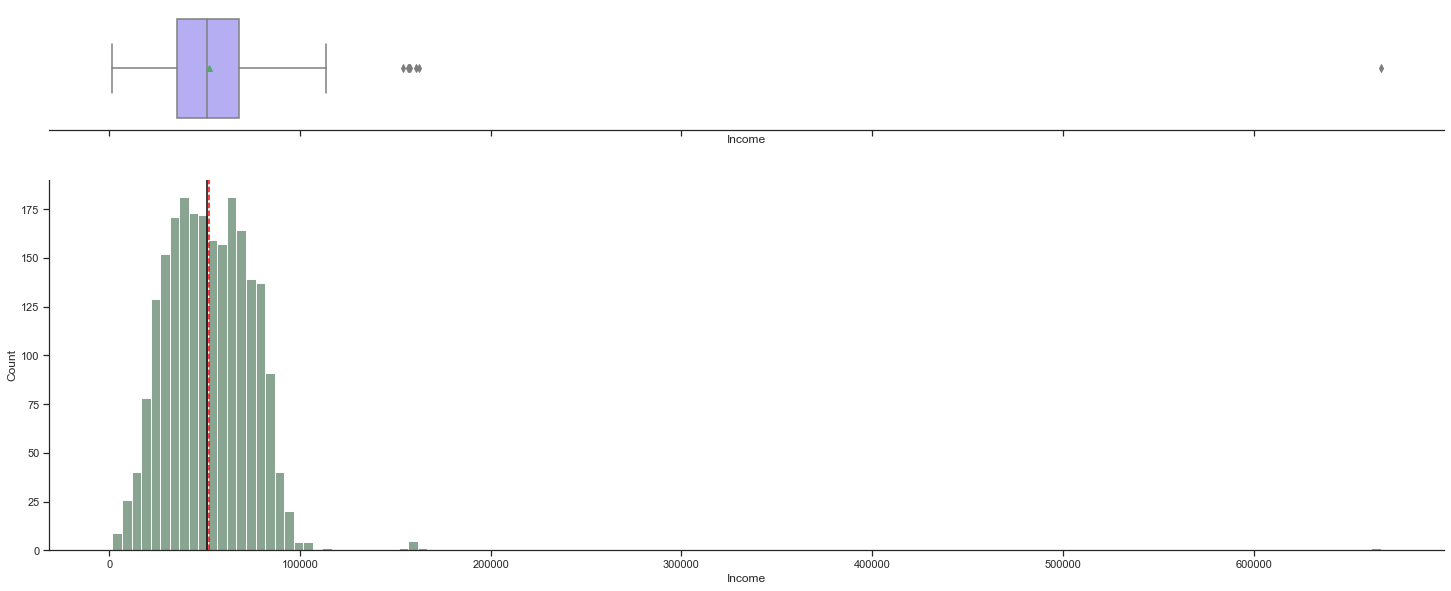

In [26]:
box_hist(df,"Income")

# Comment:
<strong>
1. There are some outlier values according the box plot and We can see at the hist plot which are they. <br>
2. I want to throw these from our dataset
</strong>

In [27]:
def outlier(df,feature):
    global df_feature_lower_bond
    global df_feature_upper_bond
    
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3-Q1
    df_feature_lower_bond = Q1 - 1.5*IQR
    df_feature_upper_bond = Q3 + 1.5*IQR
    print(f"The outlier lower bond: {df_feature_lower_bond}\nThe outlier upper bond: {df_feature_upper_bond}")
    print(f"There is {df[(df[feature]< df_feature_lower_bond) | (df[feature]> df_feature_upper_bond)].shape[0]} outlier values")
    return (df[(df[feature]< df_feature_lower_bond) | (df[feature]> df_feature_upper_bond)])
    

# Income

In [28]:
outlier(df,"Income")

The outlier lower bond: -13678.375
The outlier upper bond: 117470.625
There is 8 outlier values


,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age,Total_Spent
325,Graduation,Married,157146.0,0,0,13,1,0,1725,2,1,1,0,0,28,0,1,0,0,2013,4,29,44,1759
497,PhD,Married,160803.0,0,0,21,55,16,1622,17,3,4,15,0,28,1,0,0,0,2012,4,8,39,1761
527,Graduation,Married,666666.0,1,0,23,9,14,18,8,1,12,4,3,1,3,6,0,0,2013,2,6,44,79
731,PhD,Married,162397.0,1,1,31,85,1,16,2,1,2,0,0,0,1,1,0,0,2013,3,6,45,109
853,Master,Married,157733.0,1,0,37,39,1,9,2,0,8,0,1,0,1,1,0,0,2013,4,6,50,62
1826,Graduation,Divorced,153924.0,0,0,81,1,1,1,1,1,1,0,0,0,0,0,0,0,2014,7,2,46,6
1925,PhD,Married,156924.0,0,0,85,2,1,2,1,1,1,0,0,0,0,0,0,0,2013,8,29,72,8
2204,PhD,Married,157243.0,0,1,98,20,2,1582,1,2,1,15,0,22,0,0,0,0,2014,1,3,48,1645


In [29]:
def dropping_outliers(df,feature):
    print("Before dropping shape:",df.shape)
    df.drop(df[(df[feature] >df_feature_upper_bond)&df[feature]].index, inplace=True)
    print("After dropping shape:",df.shape)

In [30]:
df.drop( df[(df["Income"] >df_feature_upper_bond)&df["Income"]].index, inplace=True)
df.shape

(2228, 24)

# Wines

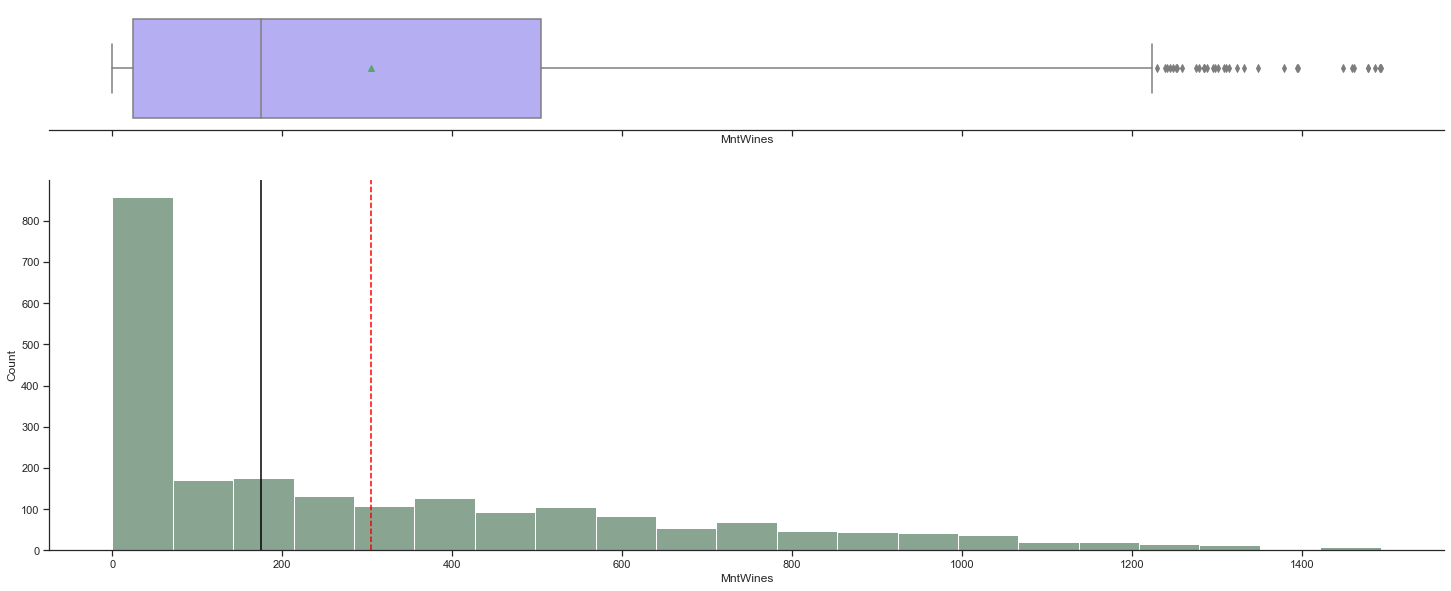

In [31]:
box_hist(df,"MntWines")

In [32]:
outlier(df,"MntWines")

The outlier lower bond: -697.5
The outlier upper bond: 1226.5
There is 35 outlier values


,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age,Total_Spent
35,PhD,Single,95169.0,0,0,1,1285,21,449,106,20,20,1,4,3,4,1,1,0,2013,9,10,34,1914
38,PhD,Single,84865.0,0,0,1,1248,16,349,43,16,16,1,2,4,9,4,1,0,2013,9,5,60,1708
77,PhD,Married,72335.0,0,0,2,1285,105,653,28,21,0,1,10,4,8,8,1,0,2012,8,13,45,2123
152,Graduation,Divorced,85683.0,0,0,6,1296,17,311,45,69,51,1,2,4,10,1,1,0,2014,3,21,67,1807
196,PhD,Divorced,71670.0,0,0,8,1462,16,128,0,0,160,1,5,3,6,6,1,0,2013,9,7,59,1787
222,PhD,Married,84169.0,0,0,9,1478,19,403,0,19,0,1,7,6,6,3,1,0,2013,7,8,39,1942
223,PhD,Married,84169.0,0,0,9,1478,19,403,0,19,0,1,7,6,6,3,1,0,2013,7,8,39,1942
376,Graduation,Single,93790.0,0,0,16,1302,68,731,89,114,45,0,6,7,12,2,1,0,2014,12,2,51,2376
402,PhD,Married,75261.0,0,0,17,1239,17,413,23,34,17,1,5,6,5,2,1,0,2013,4,23,66,1762
472,PhD,Married,70356.0,0,0,20,1349,16,249,43,16,33,2,10,6,9,6,0,0,2012,5,11,76,1739


<strong>
    Comment:
    I will not change the outliers as wine expenditure is an expenditure proportional to their income.
</strong>

# Fruits

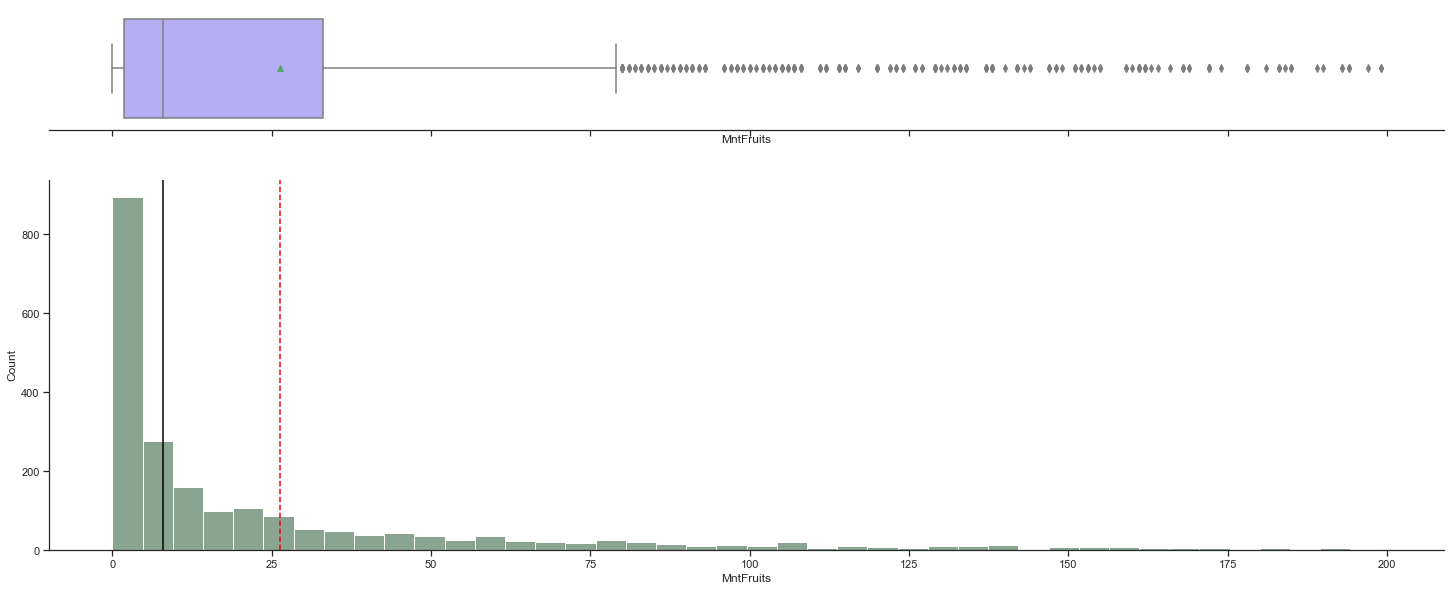

In [33]:
box_hist(df,"MntFruits")

In [34]:
outlier(df,"MntFruits")

The outlier lower bond: -45.125
The outlier upper bond: 79.875
There is 247 outlier values


,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age,Total_Spent
0,Graduation,Divorced,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0,2014,6,16,51,1206
5,PhD,Single,71691.0,0,0,0,336,130,411,240,32,43,1,4,7,5,2,1,0,2014,3,17,63,1211
6,Master,Married,63564.0,0,0,0,769,80,252,15,34,65,1,10,10,7,6,1,0,2014,1,29,67,1249
12,PhD,Divorced,67786.0,0,0,0,431,82,441,80,20,102,1,3,6,6,1,1,0,2013,7,12,62,1173
29,Graduation,Single,73170.0,0,0,1,184,174,256,50,30,32,1,5,4,6,2,0,0,2014,5,31,46,744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,Graduation,Divorced,69932.0,0,1,97,412,172,153,150,105,57,2,7,6,11,4,0,0,2013,12,6,57,1079
2197,Graduation,Married,64961.0,0,1,97,382,114,276,75,124,38,2,6,4,4,3,0,0,2012,12,23,63,1028
2215,Graduation,Married,64590.0,0,0,98,920,138,168,36,46,30,1,9,4,10,6,0,0,2012,10,14,53,1368
2218,Graduation,Single,83273.0,1,2,98,433,89,650,16,102,102,10,4,6,9,7,0,0,2012,9,25,51,1428


<strong>
The intensity of meat consumption gathers around zero. This shows us that the graph is skewed to the right. <br>
    1. $X̄>Mean>Median$<br>
    2. The mean is pulled to the right with the extreme scores, so the median is to the left of the mean.<br>
    3. I don't want to get rid of all the outliers in the data set, because some values show behavior that can be seen in the normal course of life.
</strong

# Meat

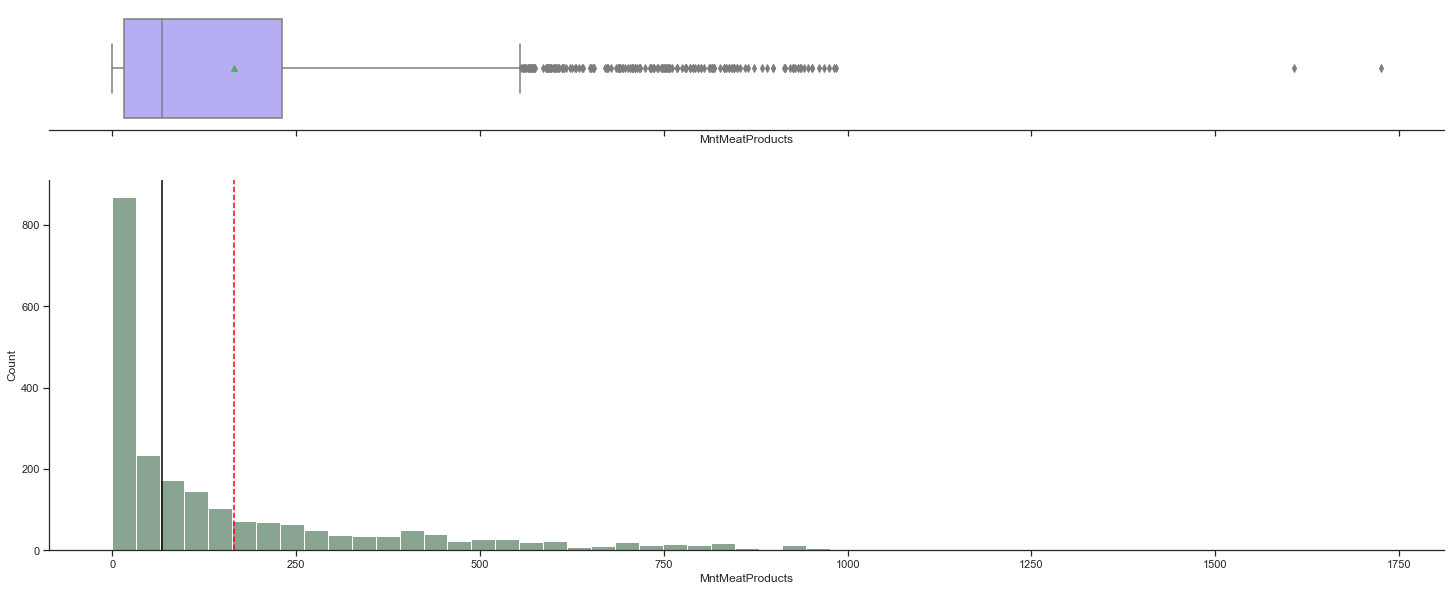

In [35]:
box_hist(df,"MntMeatProducts")

<strong>
The intensity of meat consumption gathers around zero. This shows us that the graph is skewed to the right. <br>
    1. $X̄>Mean>Median$<br>
    2. The mean is pulled to the right with the extreme scores, so the median is to the left of the mean.<br>
    3. I don't want to get rid of all the outliers in the data set, because some values show behavior that can be seen in the normal course of life.
</strong>

In [36]:
outlier(df,"MntMeatProducts")

The outlier lower bond: -306.875
The outlier upper bond: 554.125
There is 173 outlier values


,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age,Total_Spent
31,Graduation,Married,79529.0,0,0,1,423,42,706,73,197,197,1,4,8,9,2,0,0,2014,4,27,35,1662
45,Graduation,Married,64260.0,0,0,1,539,169,816,20,0,30,1,4,5,4,3,1,0,2013,11,1,60,1591
53,Graduation,Married,90369.0,0,0,2,292,51,981,224,23,17,1,4,6,6,1,1,0,2014,4,28,65,1606
77,PhD,Married,72335.0,0,0,2,1285,105,653,28,21,0,1,10,4,8,8,1,0,2012,8,13,45,2123
78,Master,Married,79143.0,0,0,2,650,37,780,27,167,32,1,6,9,13,3,0,0,2012,11,8,57,1725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,Graduation,Divorced,73455.0,0,0,98,901,61,757,186,163,20,1,6,5,10,3,0,0,2013,10,28,53,2113
2212,PhD,Divorced,90687.0,0,0,98,982,17,672,23,34,51,1,6,2,8,2,1,0,2013,5,22,38,1798
2218,Graduation,Single,83273.0,1,2,98,433,89,650,16,102,102,10,4,6,9,7,0,0,2012,9,25,51,1428
2219,Graduation,Divorced,81702.0,0,0,98,563,50,774,28,31,187,1,7,7,12,3,0,0,2012,9,23,41,1663


In [37]:
# I want to look at the value of the 10 largest 
df.MntMeatProducts.nlargest(10)

961     1725
1213    1607
1921     984
53       981
994      974
2021     968
1338     961
855      951
1368     951
2055     946
Name: MntMeatProducts, dtype: int64

In [38]:
df[df["MntMeatProducts"] > 1000]

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age,Total_Spent
961,Graduation,Married,2447.000000,1,0,42,1,1,1725,1,1,1,15,0,28,0,1,0,0,2013,6,1,42,1774
1213,Master,Married,50185.952128,0,0,53,32,2,1607,12,4,22,0,0,0,1,0,0,0,2012,12,8,43,1680


In [39]:
# To get rid of the anomaly in the top values, I convert it to a more normal value.
df["MntMeatProducts"].clip(upper=984, inplace=True)

In [40]:
df.MntMeatProducts.nlargest(10)

961     984
1213    984
1921    984
53      981
994     974
2021    968
1338    961
855     951
1368    951
2055    946
Name: MntMeatProducts, dtype: int64

# Fish

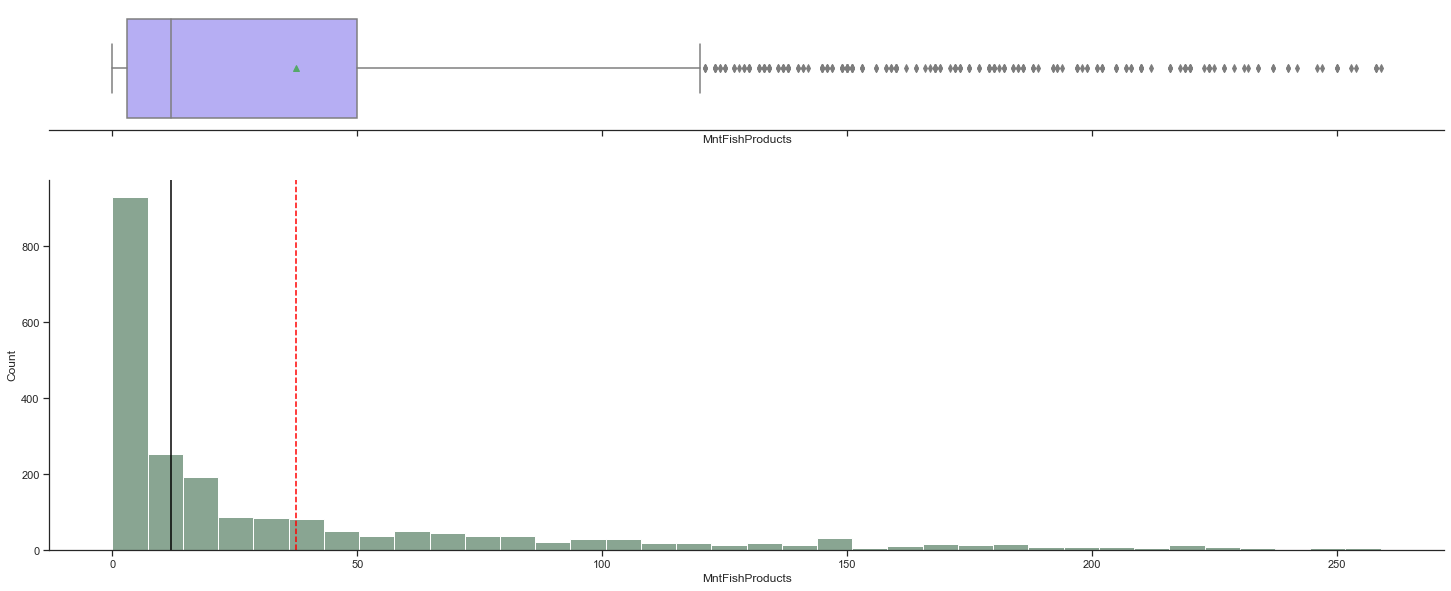

In [41]:
box_hist(df,"MntFishProducts")

<strong>
The intensity of meat consumption gathers around zero. This shows us that the graph is skewed to the right. <br>
    1. $X̄>Mean>Median$<br>
    2. The mean is pulled to the right with the extreme scores, so the median is to the left of the mean.<br>
    3. I don't want to get rid of all the outliers in the data set, because some values show behavior that can be seen in the normal course of life.
</strong>

# Sweet

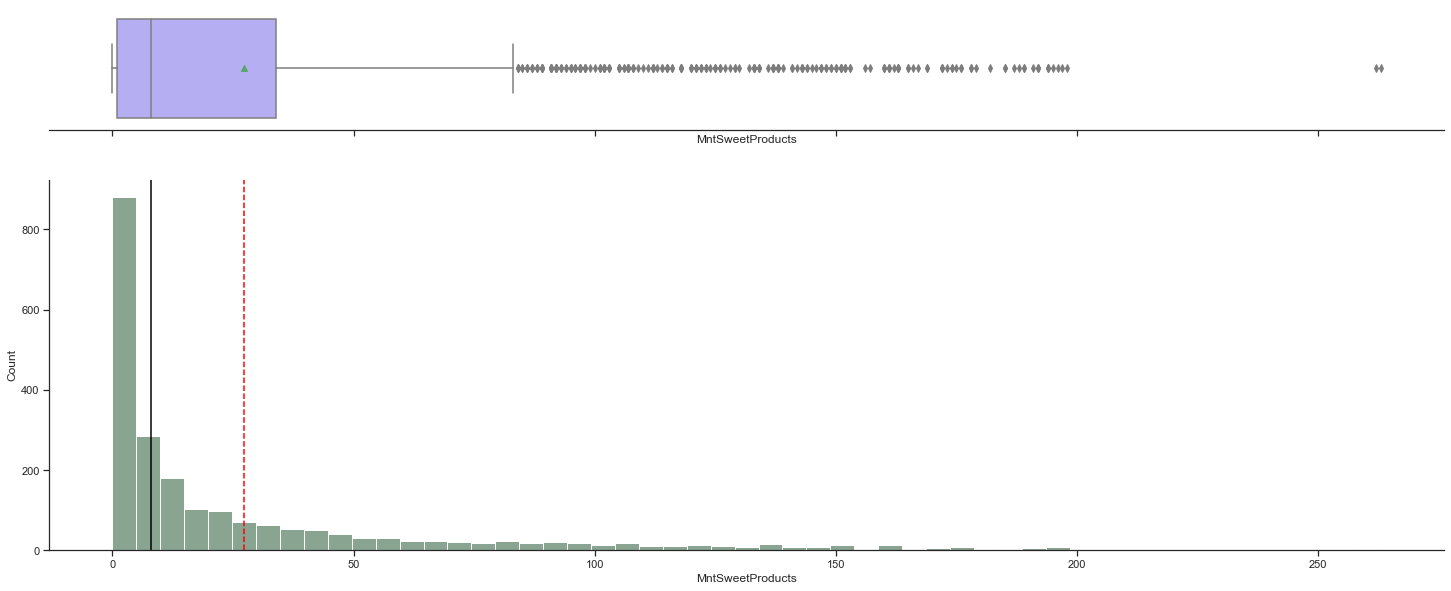

In [42]:
box_hist(df,"MntSweetProducts")

<strong>
The intensity of meat consumption gathers around zero. This shows us that the graph is skewed to the right. <br>
    1. $X̄>Mean>Median$<br>
    2. The mean is pulled to the right with the extreme scores, so the median is to the left of the mean.<br>
    3. I don't want to get rid of all the outliers in the data set, because some values show behavior that can be seen in the normal course of life.
</strong>

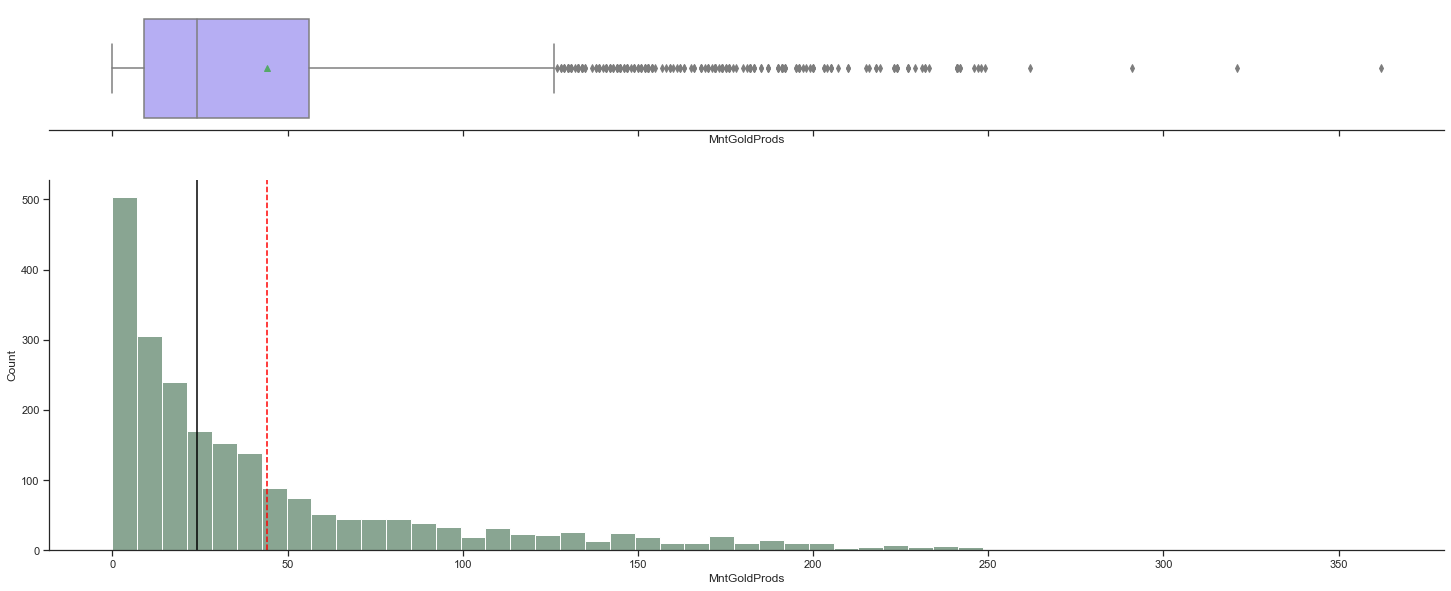

In [43]:
box_hist(df,"MntGoldProds")

In [44]:
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age,Total_Spent
0,Graduation,Divorced,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0,2014,6,16,51,1206
1,Graduation,Single,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,1,0,2014,6,15,60,600
2,Graduation,Married,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,2014,5,13,63,264
3,Graduation,Married,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,2014,11,5,54,22
4,Graduation,Single,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,2014,8,4,32,106


In [45]:
def bar_plot(variable):
    """
        input: variable eg: "Kidhome"
        output: barplot & count value
        
    """
    # Taking feature
    var = df[variable]
    # count number of categorical variable
    varValue = var.value_counts()
    
    # visualize
    plt.figure(figsize=(15,5))
    a = plt.bar(varValue.index, varValue,label=varValue)
    plt.bar_label(a, labels=round((df[variable].value_counts()/len(df[variable]) * 100),2), weight="bold")
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {} ".format(variable,varValue))

# Kidhome

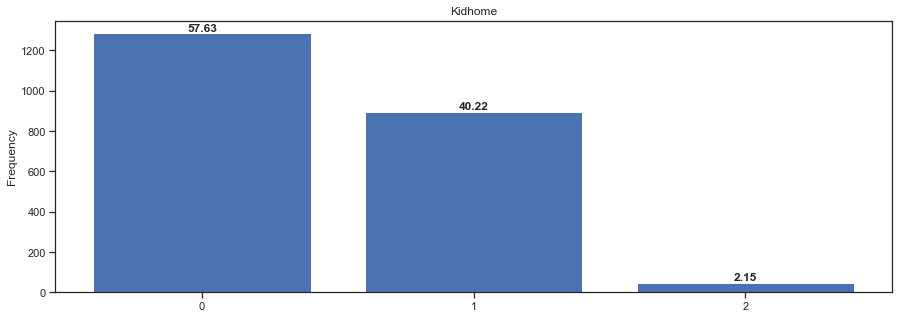

Kidhome: 
 0    1284
1     896
2      48
Name: Kidhome, dtype: int64 


In [46]:
bar_plot("Kidhome")

# Comment:
1. As we can see in the graph, those who do not have **small children** at home are more than 50 percent of the total.

# Teenhome

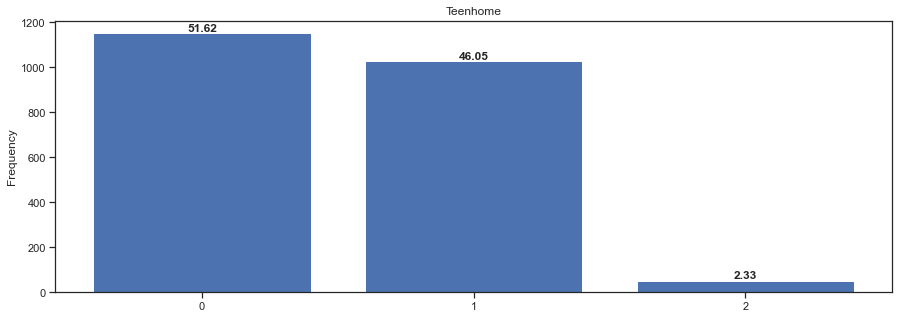

Teenhome: 
 0    1150
1    1026
2      52
Name: Teenhome, dtype: int64 


In [47]:
bar_plot("Teenhome")

# Comment:
1. As we can see in the graph, those who are not **young** at home are more than 50 percent of the total.

# Response

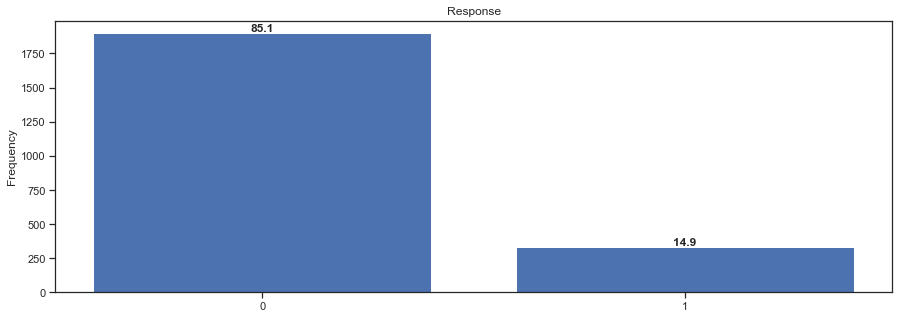

Response: 
 0    1896
1     332
Name: Response, dtype: int64 


In [48]:
bar_plot("Response")

# Comment:
1. While 85.1% of the customers do not participate in the campaigns, 14.9% participate in the campaigns.

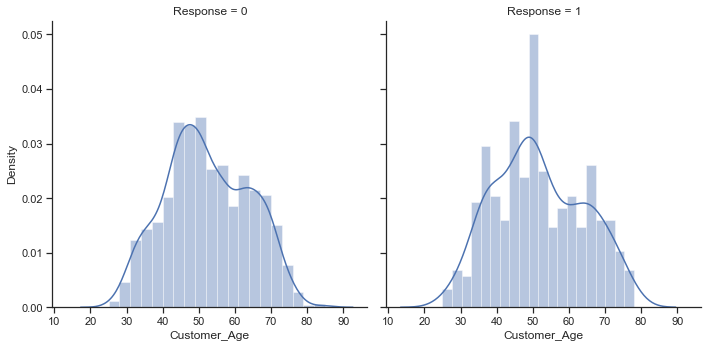

In [49]:
g = sns.FacetGrid(df, col="Response", height=5)
g.map(sns.distplot, "Customer_Age", bins= 20)
plt.show()

# Comment:
1. There has been a jump between 45-55 in age groups participating in the campaign.

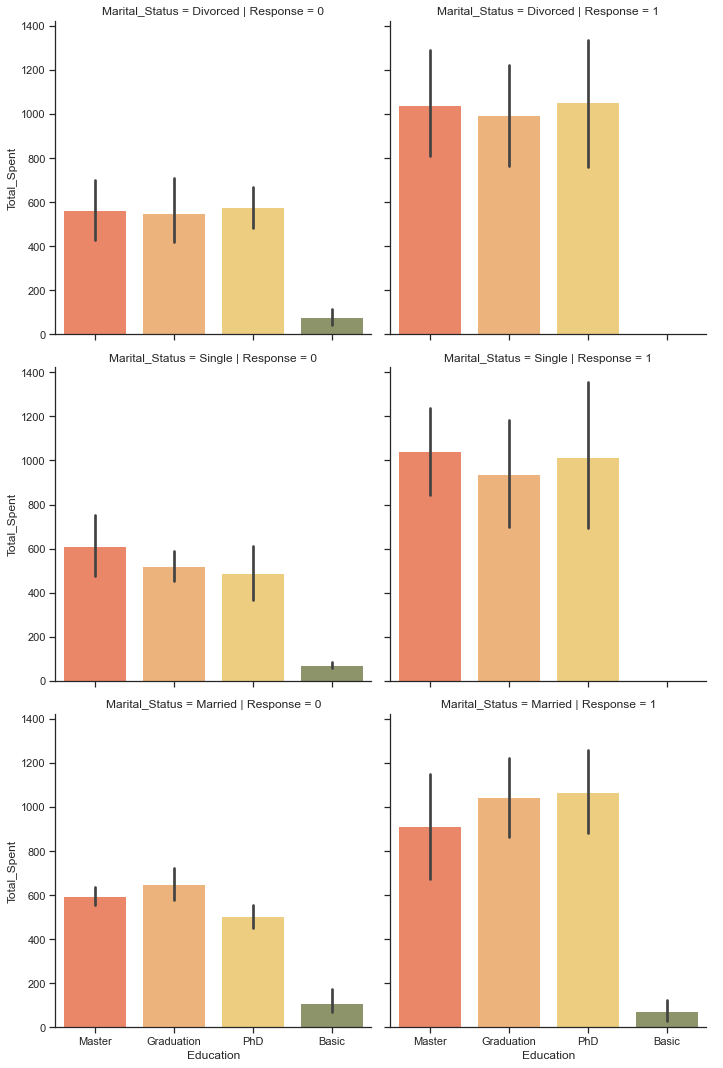

In [50]:
g = sns.FacetGrid(df, row= "Marital_Status", col= "Response",height = 5)
g.map(sns.barplot, "Education","Total_Spent",palette=sns.color_palette(["#FF7B54", "#FFB26B", "#FFD56F","#939B62"]))
g.add_legend()
plt.show()

# Comment:
1. As the spending amounts increase, the participation rates in the campaign increase.
2. In general, the most positive response came from those with PhD education level.
3. Many segments of those with a basic level of education responded negatively to the campaign and the least expenditure is seen in this group.

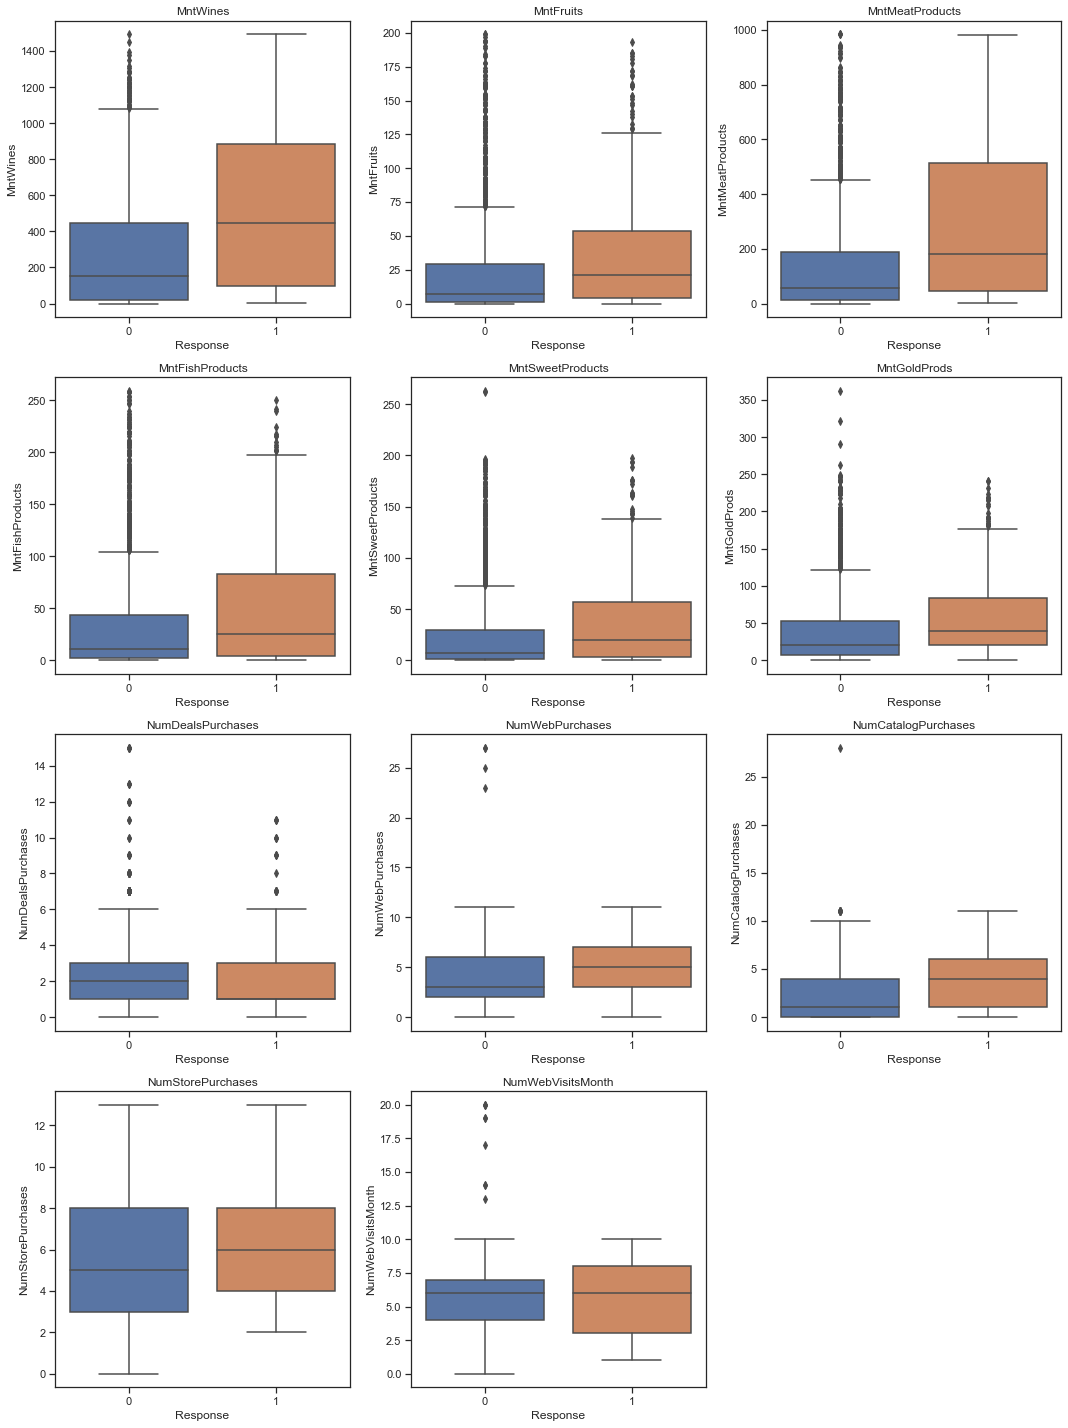

In [51]:
pair_df = df.iloc[:,6:17]
plt.figure(figsize=(15,20))
for i,column in enumerate(pair_df.columns):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(df["Response"], df[column])
    plt.title(column)
    plt.tight_layout()

 <Strong>If somebody spent much more money they accept the offer</Strong>

<AxesSubplot:xlabel='Customer_year'>

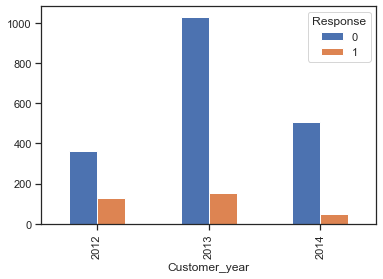

In [52]:
pd.crosstab(df["Customer_year"], df["Response"]).plot(kind="bar")

In [53]:
CustomerEachYear= df.groupby(by=df["Customer_year"])["Customer_year"].count()

In [54]:
SalesEachYear = pd.DataFrame(df.groupby(by=df["Customer_year"])['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds',"NumDealsPurchases","NumWebPurchases","NumCatalogPurchases","NumStorePurchases","NumWebVisitsMonth"].sum())
SalesEachYear

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
Customer_year,,,,,,,,,,,
2012,190899,14557,95107,21733,15714,25855,1424,2316,1446,3029,3098
2013,356941,31243,194317,43399,31986,54832,2709,4933,3177,6987,6263
2014,131409,12906,77480,18472,12844,17400,1027,1876,1244,2923,2520


<AxesSubplot:xlabel='Customer_year'>

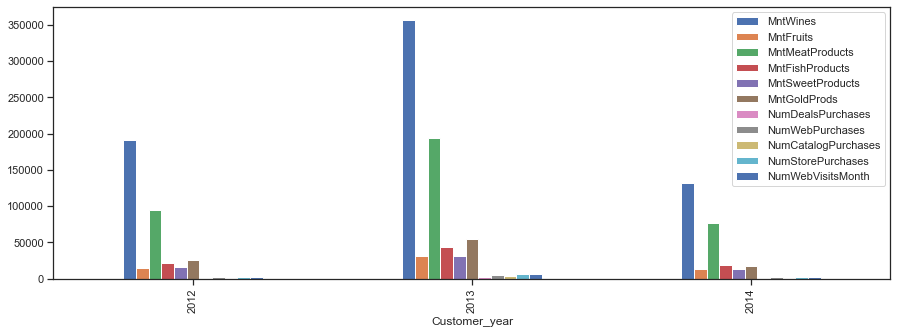

In [55]:
SalesEachYear.plot(kind="bar",figsize=(15,5))

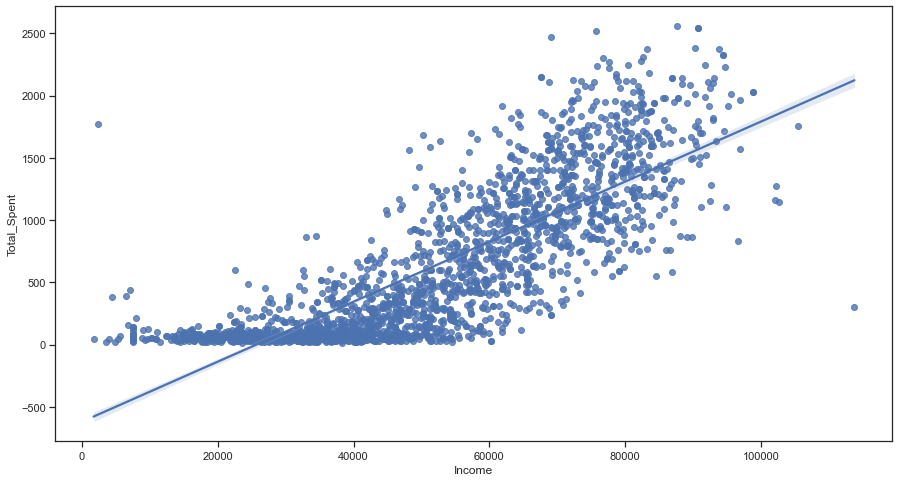

In [56]:
plt.figure(figsize=(15,8))
sns.regplot(x=df["Income"],y=df["Total_Spent"]);

# Comment:
1. There is positive correlation between income and total spent

In [57]:
def onehot(data,column):
    data = data.copy()
    dum = pd.get_dummies(data[column],prefix=column)
    data = pd.concat([data, dum], axis=1)
    data = data.drop(column,axis=1)
    return data

In [58]:
for column in ["Education", "Marital_Status"]:
    df = onehot(df,column)

# Correlation Analysis

In [59]:
df.drop(columns=["Total_Spent"],inplace=True)

In [60]:
df.corr()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single
Income,1.000000,-0.527220,0.043106,0.004872,0.728112,0.535168,0.708173,0.549839,0.549771,0.412275,-0.130546,0.493820,0.706208,0.682358,-0.644066,0.173334,-0.030216,0.025768,0.009192,-0.016836,0.213106,-0.239539,0.016342,-0.022635,0.093764,0.034513,-0.010445,-0.016779
Kidhome,-0.527220,1.000000,-0.036911,0.009364,-0.498344,-0.373683,-0.450987,-0.388885,-0.372485,-0.350567,0.232566,-0.364498,-0.517508,-0.504219,0.449711,-0.079145,0.040102,0.053008,-0.000088,-0.009230,-0.234966,0.053955,-0.000012,0.018642,-0.039964,-0.055856,0.021223,0.022141
Teenhome,0.043106,-0.036911,1.000000,0.016762,0.003425,-0.176590,-0.268172,-0.203577,-0.163553,-0.020535,0.395076,0.153519,-0.110849,0.048665,0.131559,-0.155942,0.002978,-0.007784,0.004378,-0.001977,0.361391,-0.119972,-0.020710,-0.016235,0.087301,0.071123,0.031310,-0.095936
Recency,0.004872,0.009364,0.016762,1.000000,0.016211,-0.005186,0.025914,-0.000024,0.021769,0.016384,-0.000769,-0.008890,0.029351,0.001386,-0.018586,-0.198628,0.013141,-0.030649,-0.005460,0.019663,0.018145,-0.003837,0.031661,-0.025333,-0.010168,0.002072,-0.005223,0.004330
MntWines,0.728112,-0.498344,0.003425,0.016211,1.000000,0.388899,0.598738,0.400074,0.385445,0.387237,0.014156,0.541122,0.674628,0.641140,-0.328601,0.246454,-0.039329,-0.153849,0.037545,0.000452,0.161909,-0.139195,-0.059882,-0.033224,0.160171,0.038192,-0.004449,-0.026825
MntFruits,0.535168,-0.373683,-0.176590,-0.005186,0.388899,1.000000,0.574311,0.593243,0.566856,0.389982,-0.133210,0.296491,0.514432,0.461185,-0.423467,0.123729,-0.005291,-0.055028,-0.001008,-0.020365,0.016635,-0.060340,0.112229,-0.031601,-0.080358,0.025957,-0.022642,0.004552
MntMeatProducts,0.708173,-0.450987,-0.268172,0.025914,0.598738,0.574311,1.000000,0.601837,0.555516,0.375853,-0.176727,0.325257,0.703084,0.522197,-0.546050,0.253471,-0.023560,-0.085522,0.043911,-0.014579,0.040585,-0.111736,0.061220,-0.028722,-0.002155,-0.007816,-0.028868,0.040071
MntFishProducts,0.549839,-0.388885,-0.203577,-0.000024,0.400074,0.593243,0.601837,1.000000,0.581475,0.417090,-0.140406,0.294578,0.563479,0.460259,-0.450817,0.108979,-0.021058,-0.068204,-0.013674,-0.011735,0.043595,-0.059208,0.103260,-0.002101,-0.101199,0.012615,-0.013278,0.004854
MntSweetProducts,0.549771,-0.372485,-0.163553,0.021769,0.385445,0.566856,0.555516,0.581475,1.000000,0.369697,-0.119786,0.347787,0.520258,0.447706,-0.430305,0.116421,-0.022773,-0.073175,0.002964,0.004089,0.019320,-0.057431,0.103598,-0.018117,-0.085268,0.026908,-0.018998,-0.000477
MntGoldProds,0.412275,-0.350567,-0.020535,0.016384,0.387237,0.389982,0.375853,0.417090,0.369697,1.000000,0.054227,0.422601,0.463973,0.380449,-0.254647,0.136204,-0.031040,-0.142250,0.014014,0.004907,0.062177,-0.064222,0.131332,-0.018644,-0.115896,0.038743,-0.024465,-0.004041


In [61]:
X = df.drop("Response", axis=1)
y = df["Response"]

In [62]:
for i in X:
    print(f"Correlaton between {i} and Response\t\t:==>",X[i].corr(y)*100)

Correlaton between Income and Response		:==> 17.333431486329534
Correlaton between Kidhome and Response		:==> -7.914533642278346
Correlaton between Teenhome and Response		:==> -15.594249867215312
Correlaton between Recency and Response		:==> -19.862845675069206
Correlaton between MntWines and Response		:==> 24.645429304406683
Correlaton between MntFruits and Response		:==> 12.372935496571412
Correlaton between MntMeatProducts and Response		:==> 25.347104430434293
Correlaton between MntFishProducts and Response		:==> 10.897932933597373
Correlaton between MntSweetProducts and Response		:==> 11.64214699906458
Correlaton between MntGoldProds and Response		:==> 13.62035262489857
Correlaton between NumDealsPurchases and Response		:==> 0.3390869208458988
Correlaton between NumWebPurchases and Response		:==> 14.681836916534033
Correlaton between NumCatalogPurchases and Response		:==> 23.41285316675131
Correlaton between NumStorePurchases and Response		:==> 3.6879180590382545
Correlaton between

In [63]:
mask = np.zeros_like(df.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices]=True

# P-Value

In [64]:
colNames = list(df[1:])
colNames

['Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Response',
 'Complain',
 'Customer_year',
 'Customer_month',
 'Customer_day',
 'Customer_Age',
 'Education_Basic',
 'Education_Graduation',
 'Education_Master',
 'Education_PhD',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single']

In [65]:
comb = list(combinations(colNames,2))
binaSelect = [list(i) for i in set(tuple(i) for i in comb)]
binaSelect

[['MntFruits', 'Education_Graduation'],
 ['NumWebPurchases', 'Customer_year'],
 ['Teenhome', 'MntGoldProds'],
 ['MntSweetProducts', 'Customer_Age'],
 ['Education_Graduation', 'Marital_Status_Married'],
 ['Kidhome', 'Education_Basic'],
 ['Marital_Status_Divorced', 'Marital_Status_Married'],
 ['Teenhome', 'Marital_Status_Married'],
 ['Customer_month', 'Education_Graduation'],
 ['MntSweetProducts', 'NumStorePurchases'],
 ['Customer_day', 'Education_Graduation'],
 ['NumCatalogPurchases', 'Customer_day'],
 ['NumWebPurchases', 'NumWebVisitsMonth'],
 ['Education_Basic', 'Marital_Status_Divorced'],
 ['NumWebVisitsMonth', 'Customer_month'],
 ['Customer_month', 'Marital_Status_Single'],
 ['MntFishProducts', 'Education_PhD'],
 ['Education_PhD', 'Marital_Status_Married'],
 ['Customer_day', 'Marital_Status_Single'],
 ['MntSweetProducts', 'Education_Graduation'],
 ['Recency', 'NumCatalogPurchases'],
 ['MntFishProducts', 'MntGoldProds'],
 ['Education_Graduation', 'Marital_Status_Divorced'],
 ['Teenho

In [66]:
for i in range(0, len(binaSelect)):
    dfTemp = df[binaSelect[i]]
    print(dfTemp.columns[0] + "|" + dfTemp.columns[1], "====>>>>> P_Value : ", 
          scipy.stats.pearsonr(dfTemp.iloc[:,0], dfTemp.iloc[:,1])[1])

MntFruits|Education_Graduation ====>>>>> P_Value :  1.0888507786554162e-07
NumWebPurchases|Customer_year ====>>>>> P_Value :  3.081145582849712e-15
Teenhome|MntGoldProds ====>>>>> P_Value :  0.3326115126883184
MntSweetProducts|Customer_Age ====>>>>> P_Value :  0.3620230898050782
Education_Graduation|Marital_Status_Married ====>>>>> P_Value :  0.5179565406500983
Kidhome|Education_Basic ====>>>>> P_Value :  0.010859265766192045
Marital_Status_Divorced|Marital_Status_Married ====>>>>> P_Value :  9.407117897829819e-169
Teenhome|Marital_Status_Married ====>>>>> P_Value :  0.1395644790580599
Customer_month|Education_Graduation ====>>>>> P_Value :  0.7202727903005935
MntSweetProducts|NumStorePurchases ====>>>>> P_Value :  2.813273159127125e-110
Customer_day|Education_Graduation ====>>>>> P_Value :  0.3692946963907533
NumCatalogPurchases|Customer_day ====>>>>> P_Value :  0.3427583936019573
NumWebPurchases|NumWebVisitsMonth ====>>>>> P_Value :  0.001583455333011109
Education_Basic|Marital_Statu

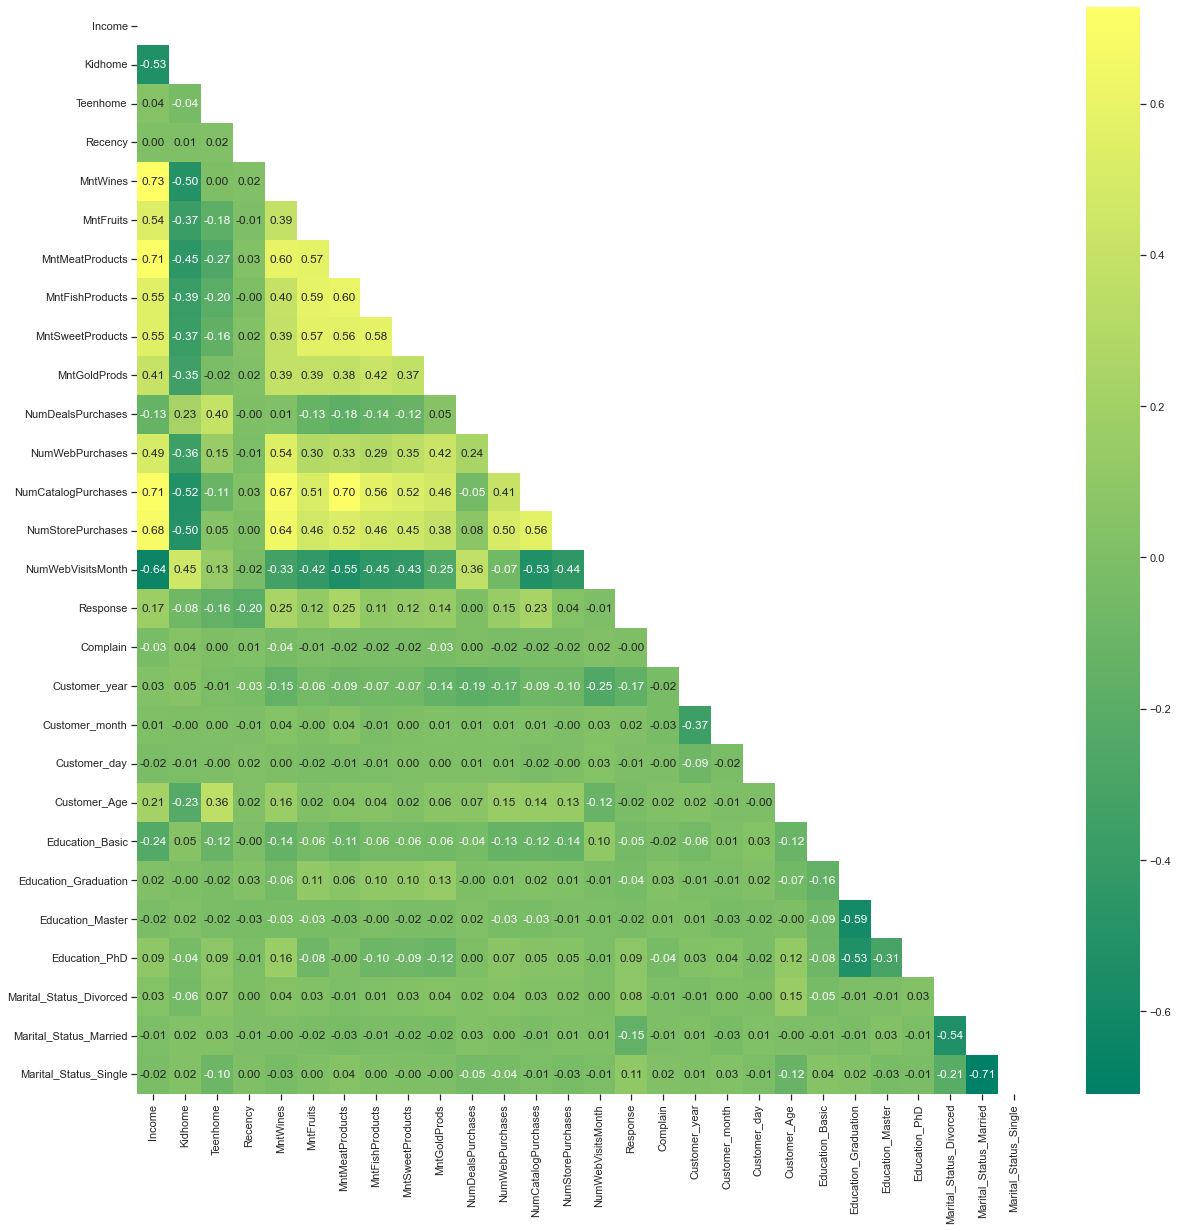

In [67]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr("pearson"), annot= True, mask=mask,fmt= ".2f",cmap="summer");

# Preparing for Machine Learning

In [68]:
response_yes = df[df["Response"]==1]
response_no = df[df["Response"]==0]

In [69]:
print(response_yes.shape,response_no.shape,df.shape)

(332, 28) (1896, 28) (2228, 28)


In [70]:
#Here we have completed the process of removing the imbalance in the data by reducing the probability of prediction from 85% to 50%.
rus = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = rus.fit_resample(X,y)
print(sorted(Counter(y_resampled).items()),y_resampled.shape)


[(0, 332), (1, 332)] (664,)


In [71]:
X_resampled["Response"]= y_resampled
display(X_resampled.head())
display(X_resampled.shape)

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Customer_year,Customer_month,Customer_day,Customer_Age,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Response
0,43824.0,1,1,18,96,1,42,12,3,32,4,3,1,4,8,0,2012,9,15,50,0,1,0,0,0,1,0,0
1,61559.0,0,1,8,279,83,88,32,14,34,1,4,2,10,3,0,2013,7,17,56,0,1,0,0,0,0,1,0
2,81169.0,0,0,47,1288,20,613,80,61,27,1,5,7,9,2,0,2013,4,14,46,0,0,1,0,0,0,1,0
3,71367.0,0,0,24,227,23,389,42,21,75,1,4,5,7,2,0,2013,8,23,62,0,1,0,0,0,1,0,0
4,59184.0,0,1,6,341,142,113,259,151,66,3,6,6,12,5,0,2012,9,9,60,0,0,1,0,1,0,0,0


(664, 28)

# Comment:
***Why did we do these actions?***
**The reason we do this undersampling or oversampling is because the data show an uneven distribution. Before doing these operations, we can see if the person is subscribed to the campaign by looking at the counting graph ourselves. In other words, this probability is a very high rate of ***85%***. We have reduced this rate to ***50%***.**

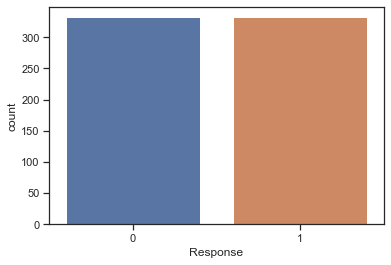

In [72]:
sns.countplot(x="Response", data=X_resampled);

In [73]:
print(X_resampled[X_resampled["Response"]==0].shape)
print(X_resampled[X_resampled["Response"]==1].shape)

(332, 28)
(332, 28)


In [74]:
X_resampled.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Customer_year,Customer_month,Customer_day,Customer_Age,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Response
count,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000
mean,54631.371734,0.403614,0.426205,43.421687,379.829819,29.518072,217.891566,43.394578,31.263554,51.855422,2.299699,4.471386,3.272590,5.823795,5.355422,0.009036,2012.911145,6.698795,15.881024,51.974398,0.019578,0.504518,0.234940,0.240964,0.150602,0.581325,0.268072,0.500000
std,22177.210998,0.526566,0.547012,29.471359,390.623649,40.910228,255.619132,57.571866,43.777390,56.759317,1.920501,2.779872,3.029683,3.169991,2.484984,0.094700,0.685728,3.400328,8.762632,11.999533,0.138650,0.500357,0.424281,0.427991,0.357931,0.493714,0.443289,0.500377
min,3502.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,1.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37070.000000,0.000000,0.000000,17.000000,34.750000,2.000000,22.000000,4.000000,2.000000,12.750000,1.000000,2.000000,1.000000,3.000000,3.000000,0.000000,2012.000000,4.000000,9.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54294.500000,0.000000,0.000000,40.000000,230.000000,12.000000,101.500000,16.000000,13.000000,31.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,2013.000000,7.000000,16.000000,51.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000
75%,72919.000000,1.000000,1.000000,69.000000,629.000000,38.250000,352.250000,63.000000,42.000000,69.000000,3.000000,6.000000,5.000000,8.000000,7.000000,0.000000,2013.000000,10.000000,23.000000,62.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,105471.000000,2.000000,2.000000,99.000000,1492.000000,193.000000,984.000000,259.000000,198.000000,321.000000,13.000000,25.000000,11.000000,13.000000,14.000000,1.000000,2014.000000,12.000000,31.000000,78.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Train - test split

In [75]:
X_resampled.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Customer_year,Customer_month,Customer_day,Customer_Age,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Response
0,43824.0,1,1,18,96,1,42,12,3,32,4,3,1,4,8,0,2012,9,15,50,0,1,0,0,0,1,0,0
1,61559.0,0,1,8,279,83,88,32,14,34,1,4,2,10,3,0,2013,7,17,56,0,1,0,0,0,0,1,0
2,81169.0,0,0,47,1288,20,613,80,61,27,1,5,7,9,2,0,2013,4,14,46,0,0,1,0,0,0,1,0
3,71367.0,0,0,24,227,23,389,42,21,75,1,4,5,7,2,0,2013,8,23,62,0,1,0,0,0,1,0,0
4,59184.0,0,1,6,341,142,113,259,151,66,3,6,6,12,5,0,2012,9,9,60,0,0,1,0,1,0,0,0


In [76]:
X = X_resampled.drop("Response", axis=1)
y = X_resampled["Response"]

In [77]:
# I divided the data set into 2 different clusters so that it is mixed from the same place in each mixing.
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(X_train.shape, X_test.shape)

(531, 27) (133, 27)


# Standard Scaler

In [78]:
scaler = StandardScaler()
scaler.fit(X_train,X_test)
X_train= pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test= pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

# Model Bulding

<h2>Logistic Regression Model</h2>

In [118]:
# I want to look best 5 score and their mean
model_score_log_reg =cross_val_score(estimator=linear_model.LogisticRegression(),X=X_train, y=y_train,cv=5)
print(model_score_log_reg)
print(model_score_log_reg.mean())

[0.71028037 0.74528302 0.74528302 0.79245283 0.82075472]
0.7628107917474873


<h2>DecisionTree Classifier Model</h2>

In [101]:
model_score_DT = cross_val_score(estimator=DecisionTreeClassifier(), X=X_train, y= y_train,cv=5)
print(model_score_DT)
print(model_score_DT.mean())

[0.72897196 0.66981132 0.68867925 0.66981132 0.73584906]
0.6986245812026097


<h2>MLPClassifier Model</h2>

In [103]:
model_score_MLP = cross_val_score(estimator=MLPClassifier(),X=X_train,y=y_train,cv=5)
print(model_score_MLP)
print(model_score_MLP.mean())

[0.71962617 0.74528302 0.72641509 0.80188679 0.80188679]
0.7590195732675012


<h2>RandomForest Classifier Model</h2>

In [107]:
model_score_RNDFR = cross_val_score(estimator=RandomForestClassifier(),X=X_train,y=y_train, cv=5)
print(model_score_RNDFR)
print(model_score_RNDFR.mean())


[0.80373832 0.69811321 0.73584906 0.81132075 0.82075472]
0.7739552107212132


# Setting HyperParameters

In [108]:
model_param = {"RandomForestClassifier":{"model":RandomForestClassifier(),
                                        "param" :{"n_estimators":[10,50,100,130],
                                                "criterion"     :["gini","entropy"],
                                                "max_depth"     :range(2,4,1),
                                                "max_features"  :["auto","log2"]}
                                        }
              ,"MLPClassifier"         :{"model":MLPClassifier(),
                                       "param"  :{"hidden_layer_sizes":[(100,),(10,50,10),(20,),(100,100)],
                                        "activation"                  :["logistic","tanh","relu"],
                                        "learning_rate_init"          :[0.001,0.05],
                                        "solver"                      :["sgd","adam"]}}
              ,"linear_model.LogisticRegression":{"model":linear_model.LogisticRegression(),
                                                  "param":{"penalty":["l1","l2","elasticnet","none"],
                                                         "C"        : np.logspace(-4,4,20),
                                                         "solver"   : ["lbfgs","newton-cg","liblinear","sag","saga"],
                                                         "max_iter" : [100,1000,2500,5000]}}}

In [111]:
scores = []
for model_name, mp in model_param.items():
    model_selection = GridSearchCV(estimator=mp["model"],param_grid=mp["param"],cv=5,return_train_score=False)
    model_selection.fit(X=X_train,y=y_train)
    scores.append({
        "model":model_name,
        "best_score":model_selection.best_score_,
        "best_params": model_selection.best_params_
    })

In [112]:
scores

[{'model': 'RandomForestClassifier',
  'best_score': 0.7606594956797743,
  'best_params': {'criterion': 'entropy',
   'max_depth': 3,
   'max_features': 'auto',
   'n_estimators': 130}},
 {'model': 'MLPClassifier',
  'best_score': 0.7891377182154822,
  'best_params': {'activation': 'logistic',
   'hidden_layer_sizes': (10, 50, 10),
   'learning_rate_init': 0.001,
   'solver': 'adam'}},
 {'model': 'linear_model.LogisticRegression',
  'best_score': 0.7778345970728268,
  'best_params': {'C': 0.08858667904100823,
   'max_iter': 100,
   'penalty': 'l2',
   'solver': 'liblinear'}}]

In [145]:
# We observed that the highest value was in the artificial neural networks algorithm and we applied it to our test set using the hyper parameters of this algorithm.
model_after_grid_MLP = MLPClassifier(activation="logistic",hidden_layer_sizes=(10, 50, 10),learning_rate_init=0.001,solver="adam",shuffle=True ,random_state=0).fit(X_train,y_train)

In [146]:
model_after_grid_MLP.score(X_test,y_test)

0.7293233082706767

In [147]:
mlp_pred = model_after_grid_MLP.predict(X_test)

In [148]:
comparison = pd.DataFrame({"Actual Values":y_test,"Predicton Values":mlp_pred})
comparison

,Actual Values,Predicton Values
281,0,0
286,0,0
473,1,1
227,0,0
436,1,1
...,...,...
628,1,1
534,1,1
443,1,1
257,0,1


In [155]:
cm = confusion_matrix(y_test,model_after_grid_MLP.predict(X_test))
cm

array([[46, 28],
       [ 8, 51]], dtype=int64)

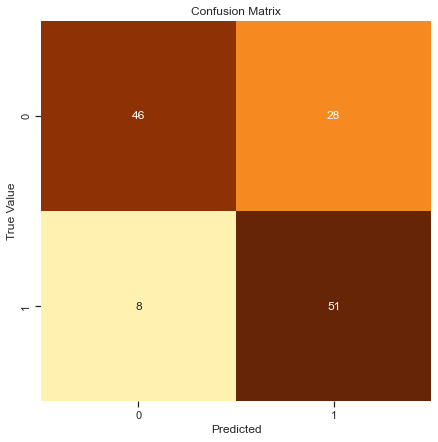

In [171]:
plt.figure(figsize=(7,7))
sns.heatmap(cm,annot=True, vmin=0, cmap="YlOrBr", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True Value")
plt.title("Confusion Matrix")
plt.show()

In [161]:
clr = classification_report(y_test, mlp_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.85      0.62      0.72        74
           1       0.65      0.86      0.74        59

    accuracy                           0.73       133
   macro avg       0.75      0.74      0.73       133
weighted avg       0.76      0.73      0.73       133



In [172]:
df.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_year,Customer_month,Customer_day,Customer_Age,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single
0,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0,2014,6,16,51,0,1,0,0,1,0,0
1,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,1,0,2014,6,15,60,0,1,0,0,0,0,1
2,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,2014,5,13,63,0,1,0,0,0,1,0
3,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,2014,11,5,54,0,1,0,0,0,1,0
4,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,2014,8,4,32,0,1,0,0,0,0,1
